## Data collection

In this notebook we collect and initially process the music data, focusing on the following databases:

* the [Billboard Hot 100](https://www.billboard.com/charts/hot-100/) website, where one can find the weekly rankings of the most popular songs, and
* the [Spotify](https://www.spotify.com) Service database, which includes the songs audio features.

To get the datasets, we will apply both web scraping, as well as API functionality. All the packages used within this notebook are listed below, with additional modules imported in particular `.py` files (see the details described further).

In [1]:
import json
from pprint import pprint

import requests
import pandas as pd
import matplotlib.pyplot as plt

### The Billboard Hot 100 Ranking

This project is focused on investigating the properties of the most popular songs and possible trends occurring in the music industry. To get the proper datasets (the collection of the most popular tracks), we will scrap the [Billboard Hot 100 Ranking](https://www.billboard.com/charts/hot-100/), which evaluates the songs on the basis of their sale record (both physical and digital sales, but also radio plays and streaming; see [here](https://en.wikipedia.org/wiki/Billboard_Hot_100) for more details). The Ranking is oriented around the United States market and can be a good predictor of the worldwide musical trends.

The Billboard List is updated weekly and published online on Tuesdays, but the date annotated on the website is postponed to the following Saturday, when the printed version of the Billboard magazine is shipped (the charts prior to 1962 are exceptions to this rule, i.e., they are marked with Monday dates). The very first record refers to the week of [August 4, 1958](https://www.billboard.com/charts/hot-100/1958-08-02/), which allows us to collect and compare the data of almost 65 years!

Each weekly chart combines 100 songs (with descending popularity) and contains their description (**artist** and **title**), as well as chart features, i.e., **this week position**, **last week position**, **peak position** and **the number of weeks on the Billboard List** (if the song re-enters the List, the counter is continued, not reset). We will use the available rankings to determine the songs of interest, which will be later sent for further processing.

Describing the scraping process concisely, its main element is the `BillboardSpider` class (a scrapy spider) defined in the <a href='music_data_scraper\music_data_scraper\spiders\billboard.py'>`billboard.py`</a> file. The class allows to scrap the charts (using the `parse` method) from the Billboard website for any chosen time frame; the latter is selected using the `resp_date` and the `ending_date` parameters (as *datetimes*). The elements of the chart are collected with particular css selectors, as given in the `parse` method definition. It should be noted that we separate the 1st chart position from the remaining ones, since the website notation between them is different (the features of the first place are bolded in the table, which results in different css selectors). Each scraped record is allocated as a `BillboardItem` object with specified fields (see the <a href='music_data_scraper\music_data_scraper\items.py'>`items.py`</a> file for details), and then initially processed within the `BillboardItemLoader` class, as defined in the <a href='music_data_scraper\music_data_scraper\itemloaders.py'>`itemloaders.py`</a> file (we strip redundant escape characters, change string numerical values into integers and transform '-' (hyphen) chars into 'NaNs' - the latter corresponds to the **last week position** field, when the song entered the List for the very first time). The items are successively yielded by the method, and when the chart exhausts, a new one (for the next week) is loaded and parsed.

The basic scraper interface can be easily built using the `'$ scrapy startproject <project_name>'` command in the terminal. To create the spider, one can navigate to the project path (`'$ cd <project_path>'`) and use the `'$ scrapy genspider <spider_name> <host_to_scrap>'` command. All the project setting are stored within the <a href='music_data_scraper\music_data_scraper\settings.py'>`settings.py`</a> file.

**Note**: Manipulating the settings, one should leave the `ROBOTSTXT_OBEY` parameter as default **True**, since it obeys the website provider's policy on web scraping (which should be highly respected).

To initiate the scraper and save the obtained data, we have to navigate to the project catalogue and run the `'$ scrapy crawl <spider_name> -O <file_name>'` command from the terminal. In our scheme, we initiate the `billboard_spider` spider and save the results into the <a href='music_data_scraper\billboard_data.json'>`billboard_data.json`</a> file. The charts are collected from the very first record (August 4, 1958) until the week of 27th May, 2023.

In the next cell we can see the sample of the records after loading the data into a `pandas` object. The values in the **last_week** column are given as floats (not integers), since the column contains 'NaNs' (when the song enters the List for the very first time).

In [2]:
hot_100 = pd.read_json('music_data_scraper/billboard_data.json')\
    .set_index('date')

hot_100.sample(5, random_state=0)

,pos,artist,song,last_week,peak_pos,wks_on_chart
date,,,,,,
1971-12-11,45,Charley Pride,Kiss An Angel Good Mornin',55.0,45,4
1977-03-26,86,Brainstorm,Wake Up And Be Somebody,86.0,86,3
2009-07-25,14,3OH!3,Don't Trust Me,11.0,7,31
1981-12-19,40,Sheena Easton,You Could Have Been With Me,48.0,40,4
2005-02-05,80,Young Buck,Shorty Wanna Ride,72.0,17,17


Due to the fact that the Billboard List annotation system has changed in 1962 (Saturday dates instead of the Monday ones), one of the charts is duplicated as shown below:

In [3]:
hot_100[hot_100.duplicated()].index.unique()

DatetimeIndex(['1962-01-06'], dtype='datetime64[ns]', name='date', freq=None)

We exclude the duplicate for clarity.

In [4]:
hot_100.drop_duplicates(inplace=True)

Moreover, examining the charts within every week, one can see that some of the position are missing (99 records instead of 100; see the cell below for details). The observed results can be confirmed with the original website (see, e.g., the [1976-12-04](https://www.billboard.com/charts/hot-100/1976-12-04/) List, where the 35th position is missing - the status as of June 2023). Since the problem is limited to few charts only, it should not have an impact on our analysis.

In [5]:
hot_100.groupby(level=0).pos.count()[lambda x: x != 100]

date
1976-12-04    99
1976-12-11    99
1976-12-18    99
1976-12-25    99
1977-01-01    99
1977-01-08    99
1977-01-15    99
1977-01-22    99
1977-01-29    99
1977-02-12    99
1977-02-19    99
1977-02-26    99
1977-03-05    99
Name: pos, dtype: int64

The Billboard dataset can be used to investigate the basic statistics of the most popular songs (and artists) over the last few decades; we will perform such analysis in the next notebook (see the <a href='1-billboard_analysis.ipynb'>`1-billboard_analysis.ipynb`</a> file for details). However, to study more detailed properties of the tracks (e.g., their audio features), we will truncate the charts to work with more concise data. This will reduce the amount of time needed to collect the records (described further), possibly without effecting the analysis quality.

We can start from assigning a score to each song in the original rankings, based on its position in particular week. Namely, the 1st place in the chart will be granted with 100 points, the 2nd place with 99 points and so on, with the last, 100th place assigned with 1 point. This simple scoring system determines the track popularity in chosen week and can be used to evaluate the overall position of the songs within the whole year.

In the next cell we assign the scores and aggregate the data yearly, where for each year we calculate the sum of points for each track (including only the songs that have been noted in the Billboard List within the considered year). Then we use the results to grab the Top 500 positions, i.e., the top 500 most popular songs of each year.

**Note**: We account for possible ties in the tail of each yearly chart (see the `nlargest` method below for details).

In [6]:
# assign the scores
hot_100 = hot_100.assign(score=lambda x: 101 - x.pos)

# get the Top 500 most popular tracks within each year
hot_500_y = hot_100.groupby([pd.Grouper(freq='Y'), 'artist', 'song']).score\
    .sum().groupby(level='date').nlargest(500, 'all').to_frame('yearly_score')\
    .droplevel(0).reset_index(level=['artist', 'song']).to_period('Y')

hot_500_y.loc['2022'].head(5) # Top 5 in 2022

,artist,song,yearly_score
date,,,
2022,Glass Animals,Heat Waves,3996
2022,Harry Styles,As It Was,3632
2022,The Kid LAROI & Justin Bieber,Stay,3596
2022,Latto,Big Energy,3394
2022,Justin Bieber,Ghost,3306


Before we transfer the rankings for further data collection, we need to process the **artist** and the **song** columns for clarity. The proper processing will increase our chances of finding the right labels using API and matching them with the original ones.

The Artists' labels include typical phrases used in the music industry to indicate collaborations between two or more artists (e.g., *'feat.'* or *'and'*) - we replace these with single commas. Moreover, we use regular expressions to remove everything contained within quotation marks or parentheses, which usually denote artists' additional aliases or other irrelevant information.

For the Songs labels, we transform double quotation marks into the single ones (for compatibility), remove the *'Theme'* and the *'From'* phrases in parentheses, and also exclude some of the special characters (e.g., dots or exclamation marks).

Finally, all the labels are stripped to remove the beginning and the ending blanks.

**Note**: The cleaning process is not straightforward and we usually have to perform many trails (and observe many errors) to determine the final way of correcting the labels. The solutions outlined below are based on comparing many draft results with the ones obtained from the Spotify API, and successively improving the cleaning keys.

In [7]:
# the elements to replace with the comma
str_colab = [' Featuring ', ' featuring ', ' Feat ', ' feat ',  'Ft.' 
    ' Feat. ', ' feat. ', ' And ', ' and ', ' With ', ' with ', 
    ' X ', ' x ', ' & ', ' \+ ', '/']

# clean the labels
hot_500_y = hot_500_y.assign(
    artist=lambda x: x.artist.replace(str_colab, ', ', regex=True)\
        .replace(r'"(.+)"', '', regex=True)\
        .replace(r'\((.+)\)', '', regex=True)\
        .replace(r'\s+$', '', regex=True)\
        .replace(r', the$', '', regex=True)\
        .replace(r',$', '', regex=True).str.strip(), 
    song=lambda x: x.song.replace('"', "'", regex=True)\
        .replace(r'\(Theme(.+)\)', '', regex=True)\
        .replace(r'\(From(.+)\)', '', regex=True)\
        .replace(r'\/.*$', '', regex=True)\
        .replace([r'\.', r'!'], '', regex=True).str.strip()
)

Having the labels cleaned, we can store the final yearly rankings in a json dictionary for possible further use - see the <a href='music_data_scraper\billboard_500_yearly.json'>`billboard_500_yearly.json`</a> file for details.

In [8]:
# build the dictionary
hot_500_y_dict = {str(date): hot_500_y.loc[date].to_dict('records') 
    for date in hot_500_y.index.unique()}

# and store it in a json file
with open('music_data_scraper/billboard_500_yearly.json', 'w') as file:
    json.dump(hot_500_y_dict, file, indent=4)

### The Spotify API

The Billboard Hot 100 Ranking allowed us to collect the data on the most popular songs over time. In the next step, we need to access the songs features, which will serve as the markers for possible comparisons. One of the very interesting and rich in terms of information database can be found in the [Spotify](https://www.spotify.com) Service, which provides various [developers' tools](https://developer.spotify.com) for the registered users (this can be done free of charge). In this project we will use the [Spotify Web API](https://developer.spotify.com/documentation/web-api); see the details in the website on how to gain your own app credentials (*client ID* and *client secret code*) required for the API authorization.

**Note**: We store the personal credentials in the <a href='spotify_credentials.json'>`spotify_credentials.json`</a> file in the project catalogue (the true values are stored only locally). To set your own credentials for possible use, change the `your_personal_ID` and `your_personal_secret` dictionary values into the ones received from the app. Keep in mind that these data should be considered highly sensitive.

In the cell given below we authorize the system to gain the access token for the API use. <u>The token is valid for an hour only</u>, after which we have to request for another one (the token can be also refreshed; see the **Tutorials** section [here](https://developer.spotify.com/documentation/web-api) for the authorization details).

In [9]:
# load the credentials
with open('spotify_credentials.json') as file:
    creds = json.load(file)
    client_id = creds['client_id']
    client_secret = creds['client_secret']

# the token request arguments
http_body = {'grant_type': 'client_credentials', 
             'client_id': client_id, 'client_secret': client_secret}
header = {'Content-Type': 'application/x-www-form-urlencoded'}

# request for the token
token_resp = requests.post('https://accounts.spotify.com/api/token', 
    data=http_body, headers=header)
print('API response code:', token_resp.status_code)

# store the token in the authorization header for further use
header_auth = {'Authorization': f'Bearer {token_resp.json()["access_token"]}'}

API response code: 200


Our goal is to collect the audio features and the genres of the songs listed in our yearly Top 500 rankings. The features provided by the Spotify Service contain many valuable information about the track properties, e.g., its acousticness, danceability or tempo (see the detailed description of the features [here](https://developer.spotify.com/documentation/web-api/reference/get-audio-features)). Using these data, we can not only compare the tracks individually, but also perform more robust analyses, e.g., outlining the general mood of music in different years (decades), or indicating the characteristics of various genres, just to mention a few. 

To get more familiar with the Spotify Web API, in the next cells we use it to find the data for one chosen song (in this example, the Taylor Swift's *Blank Space* hit).

At first we need to find the song ID (each track in the Spotify Service is assigned with an individual, unique identifier). This part will be done using the [`search`](https://developer.spotify.com/documentation/web-api/reference/search) endpoint, within which we provide the search query (the main `q` argument), as well as other parameters that allow to narrow the response results and find the information easier. In our case, we set `type=track` (search for tracks only) and `market=US` (the Billboard List is based on the USA market); for more information see the description of the `search` endpoint hyperlinked above.

In [10]:
# the queried track
artist_q = 'Taylor Swift'
song_q = 'Blank Space'

# the request arguments
api_q = 'https://api.spotify.com/v1/search'
payload_q = {
    'q': f'artist:{artist_q} track:{song_q}', 
    'type': 'track', 'market': 'US'
}

# the request
q_resp = requests.get(api_q, params=payload_q, headers=header_auth)
print('API response code:', q_resp.status_code, '\n')

# store the response in a json object and print it
q_json = q_resp.json()
pprint(q_json)

API response code: 200 

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=artist%3ATaylor+Swift+track%3ABlank+Space&type=track&market=US&offset=0&limit=20',
            'items': [{'album': {'album_type': 'album',
                                 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/06HL4z0CvFAxyc27GXpf02'},
                                              'href': 'https://api.spotify.com/v1/artists/06HL4z0CvFAxyc27GXpf02',
                                              'id': '06HL4z0CvFAxyc27GXpf02',
                                              'name': 'Taylor Swift',
                                              'type': 'artist',
                                              'uri': 'spotify:artist:06HL4z0CvFAxyc27GXpf02'}],
                                 'external_urls': {'spotify': 'https://open.spotify.com/album/2QJmrSgbdM35R67eoGQo4j'},
                                 'href': 'https://api.spotify.com/v1/albums/2QJmrSgbdM35R67eoGQo4j

The response presented above includes 13 items (see the **total** key in the dictionary tail) which refer to all available *Blank Space* song versions found in the Service (including, e.g., the karaoke version or the covers from various albums and mixtapes). Since the very first item in the list will be typically our best shot, we can grab it and use the dictionary keys to collect all the necessary properties, i.e., the artist's name, the song title and the song ID:

In [11]:
# grab the very first track
q_1 = q_json['tracks']['items'][0]

# show the track attributes
print('artist:', q_1['artists'][0]['name'])
print('song:', q_1['name'])
print('song ID:', q_1['id'])

artist: Taylor Swift
song: Blank Space
song ID: 1p80LdxRV74UKvL8gnD7ky


Having the track ID, we can easily access its features with the [`audio-features`](https://developer.spotify.com/documentation/web-api/reference/get-audio-features) endpoint. The details are presented below:

In [12]:
# the track ID
song_ID = q_1['id']

# the request arguments
api_af = 'https://api.spotify.com/v1/audio-features/'
payload_af = {'ids': f'{song_ID}'}

# the request
af_resp = requests.get(api_af, params=payload_af, headers=header_auth)
print('API response code:', af_resp.status_code, '\n')

# store the response in a json object and print it
af_json = af_resp.json()
pprint(af_json)

API response code: 200 

{'audio_features': [{'acousticness': 0.085,
                     'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1p80LdxRV74UKvL8gnD7ky',
                     'danceability': 0.753,
                     'duration_ms': 231827,
                     'energy': 0.678,
                     'id': '1p80LdxRV74UKvL8gnD7ky',
                     'instrumentalness': 1.64e-06,
                     'key': 5,
                     'liveness': 0.13,
                     'loudness': -5.421,
                     'mode': 1,
                     'speechiness': 0.0644,
                     'tempo': 96.006,
                     'time_signature': 4,
                     'track_href': 'https://api.spotify.com/v1/tracks/1p80LdxRV74UKvL8gnD7ky',
                     'type': 'audio_features',
                     'uri': 'spotify:track:1p80LdxRV74UKvL8gnD7ky',
                     'valence': 0.583}]}


Some of the data included in the response are irrelevant to our study (e.g., the **track_href** reference), but we will handle this problem during the analysis.

As one can see in the dictionary included above, the features don't contain the song genres, which may be a useful piece of information to study. Unfortunately, the genres provided by the Spotify API are in fact the artist's current genres only, and can be different than the genres of particular artist's song (e.g., artists might have changed the style throughout their careers). To access the characteristics, we need to locate the artist record in the database; this can be done easily using the artist's ID and the [`artists`](https://developer.spotify.com/documentation/web-api/reference/get-multiple-artists) endpoint.

In the example shown below, we use the *Blank Space* song item to get the Taylor Swift's ID and access her Spotify profile.

In [13]:
# the artist ID
artist_ID = q_1['artists'][0]['id']

# the request arguments
api_artist = 'https://api.spotify.com/v1/artists/'
payload_artist = {'ids': f'{artist_ID}'}

# the request
artist_resp = requests.get(api_artist, 
    params=payload_artist, headers=header_auth)
print('API response code:', artist_resp.status_code, '\n')

# store the response in a json object and print it
artist_json = artist_resp.json()
pprint(artist_json)

API response code: 200 

{'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/06HL4z0CvFAxyc27GXpf02'},
              'followers': {'href': None, 'total': 78485332},
              'genres': ['pop'],
              'href': 'https://api.spotify.com/v1/artists/06HL4z0CvFAxyc27GXpf02',
              'id': '06HL4z0CvFAxyc27GXpf02',
              'images': [{'height': 640,
                          'url': 'https://i.scdn.co/image/ab6761610000e5eb5a00969a4698c3132a15fbb0',
                          'width': 640},
                         {'height': 320,
                          'url': 'https://i.scdn.co/image/ab676161000051745a00969a4698c3132a15fbb0',
                          'width': 320},
                         {'height': 160,
                          'url': 'https://i.scdn.co/image/ab6761610000f1785a00969a4698c3132a15fbb0',
                          'width': 160}],
              'name': 'Taylor Swift',
              'popularity': 100,
              'type': 'artis

In this case the genre is determined as *'pop'* only (see the **genres** key above). This would be a little misleading for Taylor Swift's very first songs, which were rather country style than pop, so the genres of several tracks in our data may be somehow biased. Another problem might occur if the song is labeled with several (featuring) artists. In such scenario, the additional (not leading) artists' genres might be mistakenly assigned to the primary ones, which normally do not combine. To limit such cases, we will focus on the leading creator only (as described below).

**Note**: See the [Spotify Web API](https://developer.spotify.com/documentation/web-api) documentation for all the endpoints provided by the Service, which can be used to query various interesting data, including also the (registered) user ones.

As we have described in the example above, in order to get the song properties, we have to find it in the Spotify database first and then query for its features. We will automate this process for the tracks stored in our Top 500 yearly rankings as follows:

Let us define the `spotify_audio_features` function (declared in the <a href='utils.py'>`utils.py`</a> file, where we will store all our utility functions for the Project), which uses the Spotify Web API to find the audio features and the genres of the tracks from chosen data frame (the first function argument `df`; we have to provide also the `client_id` and `client_secret` credentials for collecting the API token, which is automatically refreshed by the internal `auth_update` function if it expires).

Describing the collection process shortly, in the first step we successively grab the tracks from the data frame and try to find them using the `search` API endpoint. Before each search, the labels of the artist and the song title are slightly transformed to make them more compatible with the Spotify database (e.g., we provide only the first artist if there are more creators than one, or remove the apostrophes from the song title). If the search is successful (the response contains at least one item), we compare the original track labels with the ones returned by the API to find the best match. The labels are compared using the external `labels_match` function, which examines their compatibility for chosen threshold.

After we process 50 tracks, in the next step we combine them into a batch, which is sent to the internal `save_batch` function that queries for the tracks audio features (using their Spotify IDs; we query only the matched tracks). In this step, we also access the profile of the song leading artist (the first one listed) and grab its genres. After collecting the information, the results are saved into a csv file, which is successively updated with the upcoming batches. The `spotify_audio_features` tool informs us about the current state of the data collection process and returns boolean `True` after all the tracks are processed.

The final result of the procedure can be find in the <a href='spotify_API_logs\spotify_audio_features_log.csv'>`spotify_audio_features_log.csv`</a> file.

**Notes**:\
**(i)** If the original track has not been found or matched with the Spotify database, the record is saved to the final csv file with the `match=0` flag. This scenario may happen of many reasons, e.g., the song is not available in the Service, the artist nickname has changed (compared to the moment of the song release) or the Spotify labels contain diacritics (which are absent in the Billboard List), just to mention a few. As a rule of thump, the simpler the labels (single artist, simple song title with alphabetical characters only), the higher the probability of positive matching.\
**(ii)** If we exceed the application rate limit (which prevents the users from excessive app use), it will return the 429 response code and disallow any further requests for limited amount of time. Due to the fact that the size of our data is quite big (the Top 500 rankings with 31 423 records in total) and we call the application within very short time intervals, we have encountered one rate limit exception and had to collect the data in two separate sessions (the final file is combined using two partial ones). Notably, if we reach the app limit, the `spotify_audio_features` function will return the date and the time of next possible execution.\
**(iii)** In should be noted that the API can respond in other problematic ways. Spontaneously, it returns the [502 Bad Gateway Error](https://community.spotify.com/t5/Spotify-for-Developers/Getting-a-502-bad-gateway-when-trying-to-read-me-tracks/td-p/5315584), which can be easily handled with postponing the retry request for 5 seconds (done automatically by the function). More complex issue can occur with the `audio-features` or the `artists` endpoints, if we exceed the rate limit (we use the batched versions of the endpoints to marginalize such scenario). In this case we cannot access the value of the required delay from the response headers (see, e.g., [here](https://community.spotify.com/t5/Spotify-for-Developers/retry-after-header-not-accessible-in-web-app/td-p/5433144) for details; the problem is still present as of June 2023), and so the procedure (for the unprocessed tracks) has to be postponed for an unknown amount of time. Hopefully, we haven't encountered this issue with our data.

For more details and the code, see the `spotify_audio_features` function definition in the <a href='utils.py'>`utils.py`</a> file.

In the next cell we have run the tool and collected the audio features and the genres for our data.

**Note**: The running command is commented below to prevent accidental execution, which would erase the original csv file and run the procedure from the beginning!

In [13]:
from utils import spotify_audio_features

# spotify_audio_features(hot_500_y, client_id, client_secret)

'All the batches collected!'

True

After collecting the data we can load them into a data frame and observe some of the records matched:

In [14]:
spot_af = pd.read_csv('spotify_API_logs/spotify_audio_features_log.csv', 
    sep=';')

spot_af.query('match == 1').sample(5, random_state=0)

,date,artist_orig,song_orig,artist_spot,song_spot,artist_spot_id,song_spot_id,match,genres,danceability,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
2036,1962,Bobby Curtola,Fortuneteller,Bobby Curtola,Fortuneteller,2PIiDZM2zK2J6t0sm3fz0c,5EYxarXezOkrieJr1LNFP9,1,[],0.646,...,0.000000,0.1560,0.839,111.935,audio_features,spotify:track:5EYxarXezOkrieJr1LNFP9,https://api.spotify.com/v1/tracks/5EYxarXezOkr...,https://api.spotify.com/v1/audio-analysis/5EYx...,162347.0,4.0
13555,1985,The Time,The Bird,The Time,The Bird,1EgGVV9cmmlLEsFlunjmvv,7o8UELQiECaSiVBztJTRij,1,"['funk', 'funk rock', 'minneapolis sound', 'ne...",0.675,...,0.021600,0.7840,0.453,128.837,audio_features,spotify:track:7o8UELQiECaSiVBztJTRij,https://api.spotify.com/v1/tracks/7o8UELQiECaS...,https://api.spotify.com/v1/audio-analysis/7o8U...,464333.0,4.0
10764,1979,"KC, The Sunshine Band",Who Do Ya Love,KC & The Sunshine Band,Who Do Ya Love - Single Version,3mQBpAOMWYqAZyxtyeo4Lo,0KMWN7wKaB8mGRDf5eaYsD,1,"['disco', 'mellow gold', 'new wave pop', 'soft...",0.585,...,0.000008,0.0405,0.905,120.094,audio_features,spotify:track:0KMWN7wKaB8mGRDf5eaYsD,https://api.spotify.com/v1/tracks/0KMWN7wKaB8m...,https://api.spotify.com/v1/audio-analysis/0KMW...,218427.0,4.0
19082,1997,H-Town,They Like It Slow,H-Town,They Like It Slow,21gGD9dUby5ls0belA1wqZ,3lb2ApH3z2xXxGaZJ7cCWj,1,"['boy band', 'contemporary r&b', 'new jack swi...",0.617,...,0.000000,0.1020,0.471,115.940,audio_features,spotify:track:3lb2ApH3z2xXxGaZJ7cCWj,https://api.spotify.com/v1/tracks/3lb2ApH3z2xX...,https://api.spotify.com/v1/audio-analysis/3lb2...,279533.0,4.0
26868,2014,"August Alsina, Trinidad James",I Luv This Sh*t,August Alsina,I Luv This Shit,19Fi1Rj7kk8kyiwxpXy3yM,4IeUAegXVbETb7FpgNDnSM,1,"['pop rap', 'r&b', 'southern hip hop', 'trap',...",0.643,...,0.000002,0.2220,0.405,123.942,audio_features,spotify:track:4IeUAegXVbETb7FpgNDnSM,https://api.spotify.com/v1/tracks/4IeUAegXVbET...,https://api.spotify.com/v1/audio-analysis/4IeU...,267920.0,4.0


The first three columns in the frame contain the original data from our Top 500 yearly rankings (the year, the artist and the song, stored in the **date**, **artist_orig** and **song_orig** columns, respectively). The next four elements include the Spotify artist (**artist_spot**) and song (**song_spot**) labels, and their internal IDs (the **artist_spot_id** and **song_spot_id** headers). The **match** attribute indicates if the tracks were matched (value 1) or not (value 0), while the remaining columns result from the API response and contain all the information which we have seen before for the *Blank Space* example.

As we have mentioned previously, searching for the tracks is not a straightforward process and some of the labels can occur mismatched or simply not found. The samples corresponding to both scenarios are given below.

In [15]:
pd.concat([
    spot_af.query('match == 0 and artist_spot.isnull()')\
        .sample(3, random_state=0),
    spot_af.query('match == 0 and artist_spot.notnull()')\
        .sample(3, random_state=0)
])

,date,artist_orig,song_orig,artist_spot,song_spot,artist_spot_id,song_spot_id,match,genres,danceability,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
16178,1990,"Grayson Hugh, Betty Wright",How 'Bout Us,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17517,1993,Yo-Yo,The Bonnie And Clyde Theme,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15450,1989,Henry Lee Summer,Hey Baby,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17327,1993,U.N.V.,Something's Goin' On,Unv,Something's Goin' On,1Ne6f67pPeTYmmC6h0nPUZ,7ueNdWtY35V6mpL1fnW3uW,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12360,1982,"Hughes, Thrall","Beg, Borrow Or Steal",Hughes/Thrall,"Beg, Borrow Or Steal",75lXk5oKF5H1xFt8euZZpn,3DrVmGBiGzNlRyffjZuTK6,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28364,2017,Kendrick Lamar,Yah,Kendrick Lamar,YAH.,2YZyLoL8N0Wb9xBt1NhZWg,25JDzgfvC3B2wVMoyHsals,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first three records correspond to the case when particular track was not found in the Spotify database at all. The next three rows indicate the scenario when the track was found, but we have not matched it with the original (Billboard) labels. The mismatch is usually caused by the differences in single characters or the annotation system (e.g., the last song '**Yah**' Billboard label vs. the Spotify '**YAH.**' one - with the ending dot included).

**Note**: Since at this point we have quite reasonable number of compatible records (see the diagram presented further) and possible changes in the current comparison system can disrupt the already matched records, we will leave the data as is.

The Spotify database may also lack the information on the features of specific tracks - these can be easily traced for the matched songs, using any of the headers available (below, the **danceability** one). In our case, such problem occurred for two songs only:

In [16]:
spot_af.query('match == 1 and danceability.isna()')

,date,artist_orig,song_orig,artist_spot,song_spot,artist_spot_id,song_spot_id,match,genres,danceability,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
458,1959,Frankie Avalon,A Boy Without A Girl,Frankie Avalon,A Boy Without a Girl,5zNOI87gG4RttFmYAZWaxQ,1tSUZkYZICWtuBVi2U885n,1,"['adult standards', 'bubblegum pop', 'doo-wop'...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22312,2005,Natasha Bedingfield,These Words,Natasha Bedingfield,These Words,7o95ZoZt5ZYn31e9z1Hc0a,6MFQeWtk7kxWGydnJB2y36,1,"['dance pop', 'pop', 'post-teen pop']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will conclude the data collection process with a simple bar plot visualization, showing the percentage of mismatched (or not found) tracks in each year of the Top 500 rankings. As can be seen, the most problematic records refer to the beginning years (before 1960), and the newer the tracks, the higher probability of their matching. In general, the highest mismatch ratio do not exceed the 20% threshold, with a vast majority of the results below 15%, which leaves us with at least 400 songs to operate with in each single year.

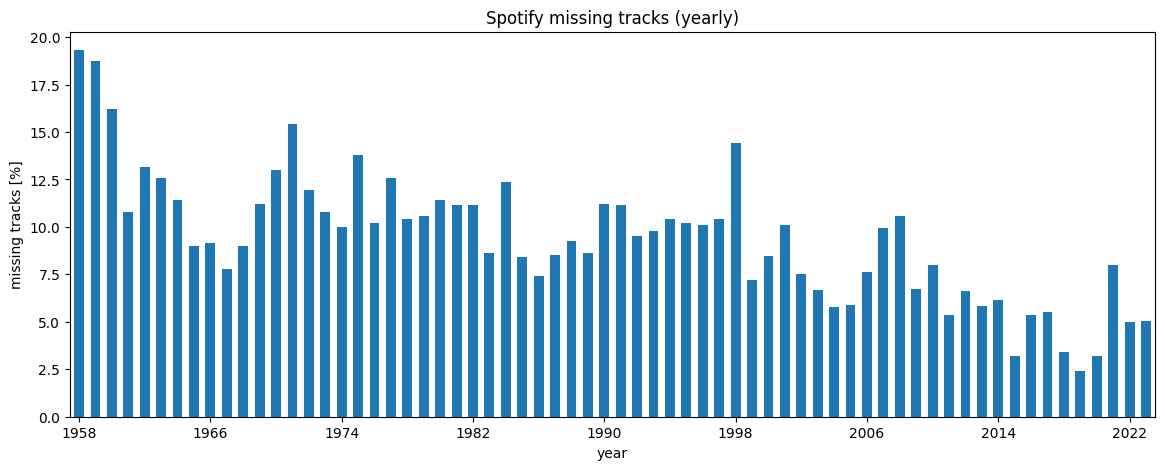

In [17]:
# missing tracks yearly (in percentages)
spot_miss = spot_af.groupby('date').danceability\
    .agg(lambda x: x.isna().sum() / x.size) * 100

# plot using bars
ax = spot_miss.plot(kind='bar', width=0.6, rot=0, figsize=(14, 5), 
    xlabel='year', ylabel='missing tracks [%]', 
    title='Spotify missing tracks (yearly)')

ax.xaxis.set_major_locator(plt.MaxNLocator('auto'))

We will use the <a href='spotify_API_logs\spotify_audio_features_log.csv'>`spotify_audio_features_log`</a> data to analyze the properties (and their possible changes) of the most successful songs over the decades.

It should be noted that all the data stored in the file have been provided using the Spotify Service and have to be used according to the Service regulations (see [here](https://developer.spotify.com/terms) for all the Terms and Conditions). Each single track can be referenced to the Spotify database using the **track_href** attribute in the original file.

In the next <a href='1-billboard_analysis.ipynb'>`1-billboard_analysis.ipynb`</a> notebook we begin our investigations, focusing on the Billboard data first.